<a href="https://colab.research.google.com/github/manushaurya/padhaibyonefourthlabs/blob/master/0630_HyperparameterTuning_MLFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outline

1.   Basic motivation of hyperparameter tuning
2.   Integrating Google colab with a local runtime (config in Google colab, Browser, Jupyter notebook)
3.   Installing MLFlow and basic use case
4.   Logging parameters, metrics with MLFlow
5.   Logging image artifacts with MLFlow
6.   Logging PyTorch models with MLFlow and loading them



In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision import datasets, transforms

import torch.nn as nn
import torch.optim as optim
import seaborn as sns

In [0]:
import mlflow
import mlflow.pytorch

# Params

In [0]:
class Params(object):
    def __init__(self, batch_size, epochs, seed, log_interval):
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.log_interval = log_interval

args = Params(256, 4, 0, 20)

# Dataset

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST('data/dataset', train=True, download=True, 
                         transform=transform)

test_set = datasets.MNIST('data/dataset', train=False, download=True, 
                         transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=args.batch_size, shuffle=False)

100.1%

Extracting data/dataset/MNIST/raw/train-images-idx3-ubyte.gz


113.5%

Extracting data/dataset/MNIST/raw/train-labels-idx1-ubyte.gz


100.4%

Extracting data/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz


180.4%

Extracting data/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


# Model

In [0]:
class Model(nn.Module):
    def __init__(self, nH = 32): 
        super(Model, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, nH),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(nH, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [0]:
def train(epoch):
    
    model.train()
    
    for batch_id, data in enumerate(train_loader):
        inputs, labels = data
        
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if batch_id % args.log_interval == 0:
            pos = epoch * len(train_loader) + batch_id
            mlflow.log_metric('train_loss', loss.data.item()/len(inputs)*1000)
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(
                epoch, batch_id * len(inputs), len(train_loader.dataset),
                100. * batch_id / len(train_loader), loss.data.item()))

In [0]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    confusion_matrix = np.zeros([10, 10]) 
    
    with torch.no_grad():
        
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_loss += loss_fn(outputs, labels).data.item()
            pred = outputs.data.max(1)[1]
            correct += pred.eq(labels.data).sum().item()
            
            for x, y in zip(pred.numpy(), labels.numpy()):
                confusion_matrix[x][y] += 1
            
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100.0 * correct / len(test_loader.dataset)
        
        pos = (epoch + 1) * len(train_loader)
        mlflow.log_metric('test_loss', test_loss*1000)
        mlflow.log_metric('test_accuracy', test_accuracy)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset), test_accuracy))
              
        if epoch == args.epochs:
            classes = np.arange(10)
            fig, ax = plt.subplots()
            im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
            ax.figure.colorbar(im, ax=ax)
            ax.set(xticks=np.arange(confusion_matrix.shape[1]),
                       yticks=np.arange(confusion_matrix.shape[0]),
                       xticklabels=classes, yticklabels=classes,
                       ylabel='True label',
                       xlabel='Predicted label',
                       title='Epoch %d' % epoch)
            thresh = confusion_matrix.max() / 2.
            for i in range(confusion_matrix.shape[0]):
                for j in range(confusion_matrix.shape[1]):
                    ax.text(j, i, int(confusion_matrix[i, j]),
                            ha="center", va="center",
                            color="white" if confusion_matrix[i, j] > thresh else "black")
              
            fig.tight_layout()
              
            image_path = 'images/%s.png' % (expt_id)
            plt.savefig(image_path)
            mlflow.log_artifact(image_path)
            

# Hyperparameter tuning loop


LR = 0.01, Momentum = 0.90, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.279
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.948
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.471
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.429
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.374
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.413
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.265
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.379
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.286
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.343
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.269
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.246

Test set: Average loss: 0.0011, Accuracy: 9261/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.362
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.194
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.210
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.275
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.252
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.299
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.270
Train Epoch:

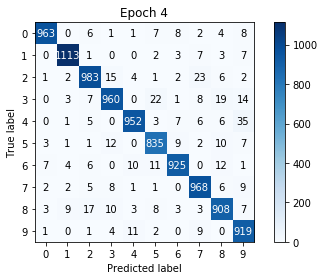

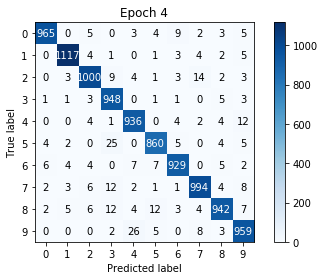

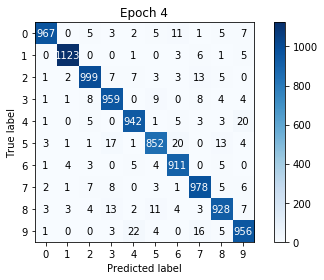

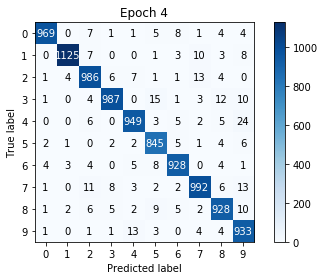

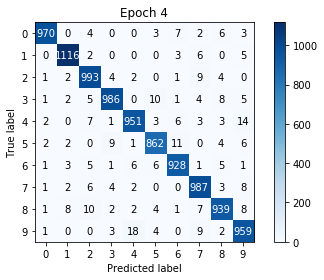

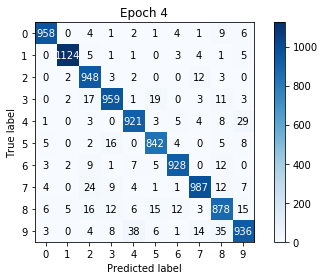

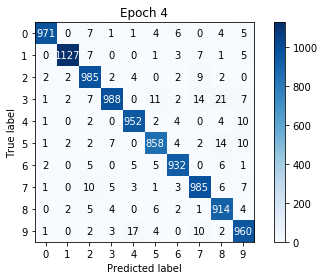

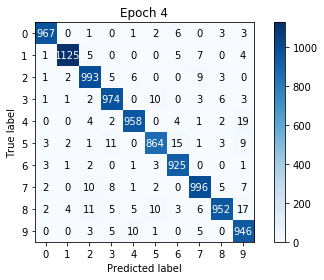

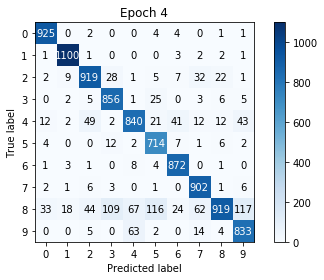

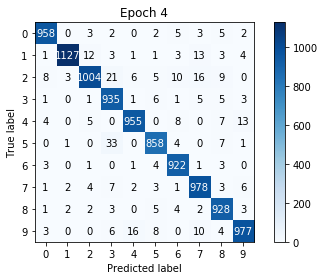

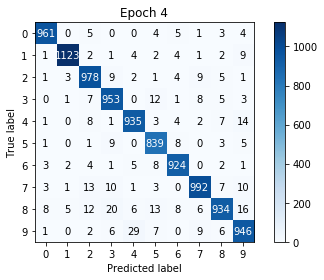

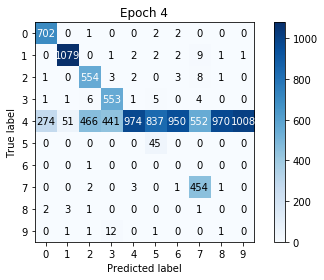

In [14]:
expt_id = mlflow.create_experiment('Fixed nH')
mlflow.set_experiment('Fixed nH')

for lr in [0.01, 0.02, 0.05, 0.1]:
    for momentum in [0.9, 0.95, 0.99]:
        for hidden_nodes in [48]:
        
            expt_id = '%d_%d_%d' % (int(lr*100), int(momentum*100), hidden_nodes)

            print('\nLR = %.2f, Momentum = %.2f, Hidden nodes = %d\n' % (lr, momentum, hidden_nodes))

            model = Model(hidden_nodes)

            loss_fn = nn.CrossEntropyLoss()
            opt = optim.SGD(model.parameters(), lr=lr, momentum = momentum)

            with mlflow.start_run() as run:  
                for key, value in vars(args).items():
                    mlflow.log_param(key, value)
                mlflow.log_param('lr', lr)
                mlflow.log_param('momentum', momentum)
                mlflow.log_param('hidden_nodes', hidden_nodes)

                for epoch in range(1, args.epochs + 1):
                    train(epoch)
                    test(epoch)

                mlflow.pytorch.log_model(model, "models")

# Loading and visualising a model

In [0]:
model_load = mlflow.pytorch.load_model('runs:/5c7f0ded9d1b403782cd9880e78aaebb/models')

Refer https://www.mlflow.org/docs/latest/tracking.html#artifact-locations

In [25]:
print(model_load)

Model(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=10, bias=True)
  )
)


In [0]:
weight_layer0 = list(model_load.parameters())[0].data.numpy()

In [27]:
print(weight_layer0.shape)

(48, 784)


[]

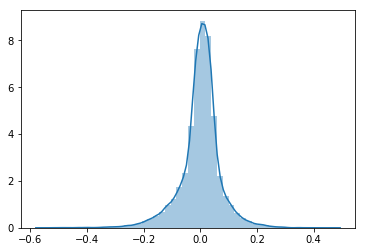

In [28]:
sns.distplot(weight_layer0.ravel())
plt.plot()

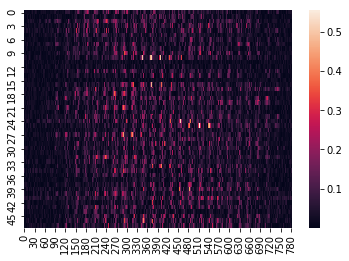

In [29]:
sns.heatmap(np.abs(weight_layer0))
plt.show()

In [0]:
weight_layer1 = list(model_load.parameters())[2].data.numpy()

In [31]:
weight_layer1.shape

(10, 48)

[]

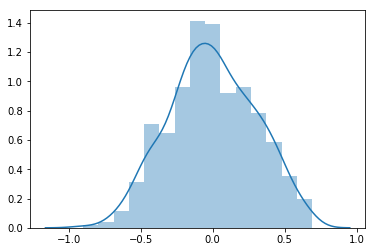

In [32]:
sns.distplot(weight_layer1.ravel())
plt.plot()

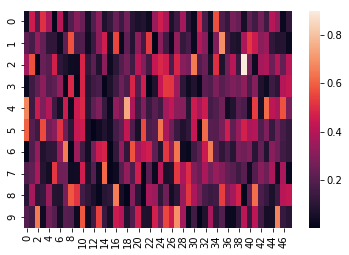

In [33]:
sns.heatmap(np.abs(weight_layer1))
plt.show()

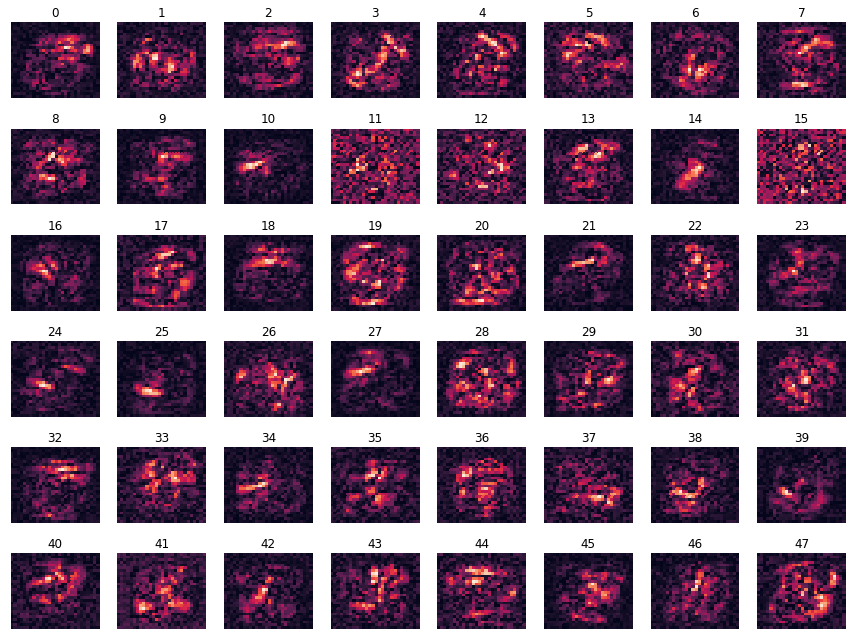

In [34]:
nrows = 6
ncols = 8
fig = plt.figure(figsize=(1.5*ncols, 1.5*nrows))

for i in np.arange(48): 
    ax1 = fig.add_subplot(nrows, ncols, i+1)
    sns.heatmap(np.abs((weight_layer0[i, 0:784]).reshape(28, 28)), ax = ax1, cbar=False)
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_title(i)
plt.tight_layout()
plt.show()